# Experiment 1. How good is base GPT at remembering instructions?

In [ ]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.4
    Uninstalling openai-1.54.4:
      Successfully uninstalled openai-1.54.4


In [ ]:
import os
from google.colab import userdata
import openai
import random
from openai import OpenAI
os.environ['OPENAI_API_KEY'] = userdata.get('OpenAI_api_key')

client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

In [ ]:
### Testing function that alternates between user and assistant for generating synthetic conversations.

def generate_chatgpt_response(
    model: str = "gpt-4o-mini",
    max_tokens: int = 125,
    isUser: bool = False,
    hist: list = [],
    max_turns: int = 10
) -> str:

    try:
        if len(hist) >= max_turns - 2 and isUser:  #simulating dementia
          bad_questions = ['What color is the item?', 'What is the item?', 'How expensive is this item?',
                           'What cakes can I make with this item', 'What emotion do you say this item makes you feel?']
          # print("[forcing BAD QUESTION ... ]")
          isUser = False
          hist.append({"role":"user", "content": random.choice(bad_questions)})
        elif random.random() > 0.9 and isUser:
            isUser = False
            # print('[forcing FORGET ...]')
            hist.append({"role":"user", "content": "Sorry what are we doing again?"})
        elif random.random() > 0.8 and isUser:
            isUser = False
            # print('[forcing HINT ...]')
            hist.append({"role":"user", "content": "I'm stuck. Could I get a thorough hint?"})
        response = client.chat.completions.create(
            model=model,
            messages=hist,
            max_tokens=max_tokens,
            temperature = 0.7
        )
        message = response.choices[0].message.content.strip()
        return isUser, hist, message
    except openai.OpenAIError as e:
        return f"Error in ChatGPT API: {str(e)}"

In [ ]:
### Experiment 1: Simulated Conversation


hist = [ {"role": "assistant", "content": '''You are a helpful assistant who has years of cognitive training experience.
            Be engaging, sympathetic, and encouraging in your responses. You will play a game with the user to guess an object.
            Only answer yes or no questions from the user. If the user is stuck, provide a hint. When the user gets a correct answer, congratulate them.'''},
            {"role": "user", "content": '''Great I'm going to be playing a memory game.
            My memory is not good so I will need some help. I will occasionally ask non-yes or no questions.
            Here's my first question. Is it a living thing?'''}
        ]

instruction_collapsed = []

for max_len in range(10, 60, 10):
  cnt = 0
  for trial in range(10):
    isUser = False
    for i in range(max_len):
      isUser, hist, response = generate_chatgpt_response(isUser = isUser, hist = hist, max_turns = max_len)
      temp = {"role": "user" if isUser else "assistant", "content": response}
      print(f'{"user" if isUser else "gpt"}:{response}')
      hist.append(temp)
      for i in range(len(hist)):
        if hist[i]['role'] == 'user':
          hist[i]['role'] = 'assistant'
        else:
          hist[i]['role'] = 'user'
      isUser = not isUser

    # trial is finished.
    with open(f'data/max_len_{max_len}_trial_{trial}.txt', 'w') as fp:
      fp.write(hist)
    hist.append({'role':'user', 'content': 'In the past conversation, did you answer non-yes or no questions?  Hints do not count as answering the question. Answer with one word, yes or no.'})
    response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=hist,
            max_tokens=5,
            temperature = 1
        )
    message = response.choices[0].message.content.strip()
    if 'yes' in message.lower():
      cnt += 1
    cnt += 1

  instruction_collapsed.append(cnt)


gpt:Let's stick to yes or no questions for the game. Feel free to ask your yes or no questions to guess the object!
user:Got it! Is the object you're thinking of a living thing?
gpt:No.
user:Is the object something that you can hold in your hand?
gpt:Yes.
user:Is the object commonly found in a household?
gpt:Yes.
gpt:Remember, let's stick to yes or no questions for the guessing game! If you're stuck, I can give you a hint. Would you like a hint?
gpt:I can only answer yes or no questions for the game. Would you like to ask if the item is expensive?
gpt:I can't answer that directly. Please ask a yes or no question about the object! For example, you could ask, "Is the object expensive?"
gpt:No.
gpt:I can only respond to yes or no questions for the game. Would you like to ask something like, "Does this item make people happy?"
gpt:I can’t reveal the item directly! Please continue guessing with yes or no questions. Would you like to ask another question?
gpt:I can only answer yes or no ques

KeyboardInterrupt: 

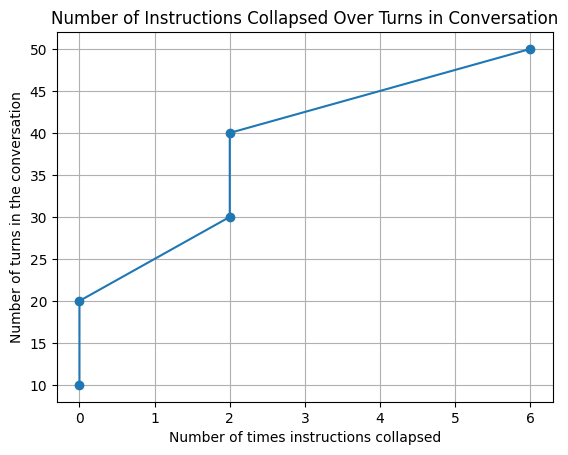

In [ ]:

import matplotlib.pyplot as plt

y = [10, 20, 30, 40, 50]
plt.plot(instruction_collapsed, y, marker='o')

plt.xlabel('Number of times instructions collapsed')
plt.ylabel('Number of turns in the conversation')
plt.title('Number of Instructions Collapsed Over Turns in Conversation')
plt.grid(True)
plt.show()


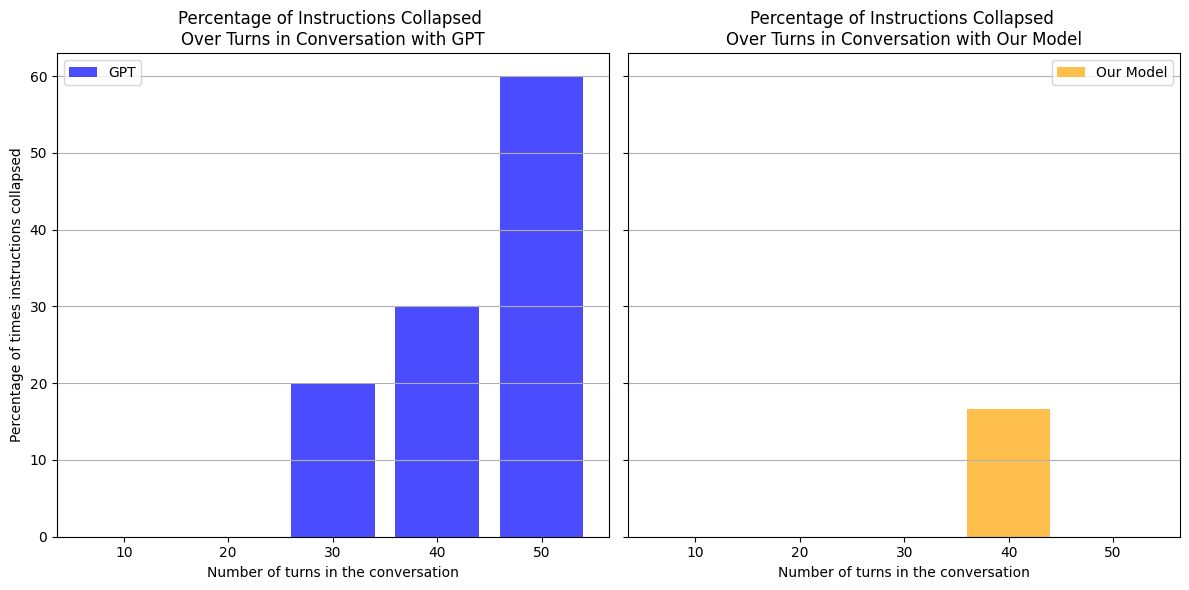

In [13]:
import matplotlib.pyplot as plt

# From our testing, in instruction_collapsed2, we only have 1 miss out of 6 on 40 turns.

instruction_collapsed2 = [0, 0, 0, 1/6 * 100, 0]
y = [10, 20, 30, 40, 50]
instruction_collapsed = [x * 10 for x in instruction_collapsed]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)


axes[0].bar(y, instruction_collapsed, width=8, label="GPT", color='blue', alpha=0.7)
axes[0].set_xticks([10, 20, 30, 40, 50])
axes[0].set_xlabel('Number of turns in the conversation')
axes[0].set_ylabel('Percentage of times instructions collapsed')
axes[0].set_title('Percentage of Instructions Collapsed \nOver Turns in Conversation with GPT')
axes[0].grid(True, axis='y')
axes[0].legend()

axes[1].bar(y, instruction_collapsed2, width=8, label="Our Model", color='orange', alpha=0.7)
axes[1].set_xticks([10, 20, 30, 40, 50])
axes[1].set_xlabel('Number of turns in the conversation')
axes[0].set_ylabel('Percentage of times instructions collapsed')
axes[1].set_title('Percentage of Instructions Collapsed \nOver Turns in Conversation with Our Model')
axes[1].grid(True, axis='y')
axes[1].legend()
plt.tight_layout()
plt.show()


# Experiment 2: How good is GPT memory?

In [ ]:
# We had weeks 1 by 1 in json variables before writing all to a json which was way easier.

In [ ]:
week_1 = {
  "Monday": "Monday, You took the morning off to visit a nearby museum, enjoying the exhibits and immersing yourself in the flying zebras. The afternoon was dedicated to catching up with old friends, and you met up with Rachel and Anna at a cozy café. The three of you reminisced about old times and caught up on each other’s lives. In the evening, you treated yourself to a nice dinner at your favorite restaurant, savoring every bite and appreciating the simple joys of the week.",

  "Tuesday": "On Tuesday, you kicked off the week with a peaceful morning jog through the park, feeling energized and ready to tackle the day. Afterward, you grabbed a quick breakfast with your friend Liam at a local diner, where you exchanged updates on personal projects and upcoming goals. The rest of the morning was spent catching up on emails and preparing for a meeting with your team. In the afternoon, you dove into work, finalizing details for an upcoming presentation. By the time you left the office, you felt accomplished and optimistic about the days ahead.",

  "Wednesday": "Wednesday was an eventful day as you volunteered at a community event to help organize a charity fundraiser. You and your friend Mia spent the morning setting up booths, organizing donations, and planning activities for the event. The whole team worked together efficiently, and by the time the event kicked off, everything was in place. The afternoon was spent interacting with guests, helping them with activities, and enjoying the positive atmosphere. The day ended with a sense of fulfillment, knowing you made a difference in the community.",

  "Thursday": "Thursday started off with a busy day at work, where you spent the morning in meetings and brainstorming sessions with colleagues. You collaborated closely with James on a new marketing strategy, and the two of you came up with some exciting ideas. The afternoon flew by as you worked on a proposal, fine-tuning the details and preparing it for submission. After a productive day, you took a break in the evening to watch a movie at home, unwinding with a bowl of popcorn and some well-deserved relaxation.",

  "Friday": "Friday was an exciting day filled with creativity. You attended a design workshop in the morning, where you learned new techniques for graphic design and brainstormed fresh ideas for an upcoming project. The hands-on session sparked your creativity, and you left feeling inspired and motivated. In the afternoon, you worked on incorporating the new techniques into your designs, and by the time you wrapped up for the day, you were proud of the progress you had made. The evening was spent with a quiet dinner at home, reflecting on your creative growth.",

  "Saturday": "Saturday was all about adventure as you took a spontaneous road trip with your brother Tom. You both headed to a nearby beach town, enjoying the scenic drive along the coast. Once there, you spent the day walking along the shoreline, trying local seafood, and exploring the small shops. The weather was perfect, and the peaceful surroundings helped you unwind. As the sun set, you grabbed some ice cream and watched the waves, feeling grateful for the unexpected getaway.",

  "Sunday": "Sunday was a day of relaxation and self-care. You spent the morning sleeping in and having a leisurely breakfast at home, indulging in your favorite pancakes. In the afternoon, you treated yourself to a spa day, complete with a massage and a facial. The calming atmosphere allowed you to fully recharge and unwind. Later in the day, you went for a long walk through a nearby nature reserve, connecting with the outdoors and reflecting on the past week. By the evening, you felt restored and ready to take on the new week with renewed energy."
}




In [ ]:
week_2 = {
  "Monday": "On Monday, you started your week with a relaxed morning at the local coffee shop, meeting up with your friend Sarah for a much-needed catch-up. Over cappuccinos, the two of you shared updates on life, talking about everything from work to personal projects. Afterward, you spent a few hours at the library, diving into research for an upcoming project. The peaceful environment helped you focus, and you made significant progress. By the time the evening rolled around, you were feeling accomplished and ready to tackle the rest of the week.",

  "Tuesday": "Tuesday was an adventurous day as you decided to take a day trip to Aspen. You and your cousin Mark made the drive early in the morning, eager to spend the day hiking in the mountains. The weather was perfect for an outdoor excursion, and you both hiked up to the summit, enjoying the incredible views of the surrounding valleys. At the top, you sat down for a picnic by the lake, enjoying sandwiches and taking in the beauty of the landscape. After a leisurely day of exploration, you both made your way back home, feeling recharged and full of stories to share.",

  "Wednesday": "Wednesday was a productive day, starting with a busy morning at work. You collaborated with your colleague Alex on a crucial presentation for an upcoming meeting, and the two of you worked tirelessly to ensure that every detail was perfect. The day flew by as you tackled various tasks and made steady progress on your project. In the evening, you treated yourself to some relaxation by attending a yoga class with your friend Emma. The class was a great way to unwind after a long day, and you left feeling calm and rejuvenated, ready for whatever the next day would bring.",

  "Thursday": "Thursday brought a shift in focus as you attended a networking event downtown. The event was a great opportunity to connect with other professionals, and you had meaningful conversations with potential business partners, including Rachel and Sam. Both of them work in the tech industry, and you discussed possible collaborations and shared ideas on emerging trends. The event lasted most of the day, and by the end, you felt inspired and energized by the new connections you had made. You finished the evening reflecting on the possibilities the event might open up for your career.",

  "Friday": "Friday was a more relaxed day, giving you the chance to unwind after a busy week. You spent the morning at the park, reading a novel you've been meaning to finish, soaking in the fresh air and the peaceful surroundings. In the afternoon, you got creative in the kitchen, baking cookies with your niece Lily. The two of you laughed and chatted as you mixed the ingredients and decorated the cookies. In the evening, you hosted a dinner party at your home, inviting friends David and Jessica over for a night of delicious food, great conversation, and lots of laughter. The evening was full of good vibes and positive energy, leaving you feeling grateful for your close circle of friends.",

  "Saturday": "Saturday was a day spent with family, enjoying a backyard barbecue at your house. The sun was shining, and you spent the afternoon grilling and catching up with relatives. Aunt Nora and Uncle Steve were there, sharing stories from their recent travels, while you and the rest of the family chatted about everything from childhood memories to current events. The food was fantastic, and everyone relaxed in the warmth of the afternoon, enjoying each other's company. By the time the evening arrived, the backyard was filled with laughter, and you felt connected and grounded after a day spent with loved ones.",

  "Sunday": "Sunday was a quieter day, giving you a chance to reflect and recharge. You spent the morning at home, enjoying a slow start to the day with a cup of tea and some light reading. Afterward, you took a long walk around the neighborhood, taking in the crisp air and the sights of the local park. The walk gave you the space to clear your mind and prepare for the busy week ahead. In the afternoon, you organized your thoughts, planned your schedule, and set your intentions for the upcoming days. It was a peaceful end to a fulfilling week, leaving you ready to take on new challenges and opportunities."
}


In [ ]:
week_3 = {
  "Monday": "On Monday, you kicked off the week with an early morning walk around the neighborhood, enjoying the crisp air and peaceful streets. Afterward, you headed to a cozy café, where you met your friend James for breakfast. Over freshly brewed coffee and croissants, you caught up on each other's lives, discussing everything from work to upcoming travel plans. In the afternoon, you dove into work, tackling a series of important emails and preparing for a big meeting the next day. By the evening, you were feeling productive and accomplished, so you treated yourself to a quiet night in, reading a new book and unwinding.",

  "Tuesday": "Tuesday was filled with excitement as you took a spontaneous trip to a nearby beach town. The drive was scenic, and you enjoyed the peaceful solitude of the open road. Upon arriving, you met up with your college friend Rachel, who now lives in the area. You spent the day exploring the beach, chatting about old memories, and sampling fresh seafood at a local restaurant. The highlight of the day was a sunset walk along the shore, where the colors of the sky reflected on the calm waters. After saying goodbye to Rachel, you drove back home, feeling refreshed and grateful for the short getaway.",

  "Wednesday": "Wednesday was a busy workday, starting with a morning brainstorming session with your team at the office. You worked on a creative project that had been in the works for weeks, collaborating closely with your co-workers, including your manager, David. The brainstorming session was productive, and by the afternoon, you had a solid plan in place for the next phase. After work, you treated yourself to a well-deserved break by meeting your friend Lily for a casual dinner at a trendy new restaurant in town. The food was amazing, and the two of you spent hours chatting and catching up on life.",

  "Thursday": "On Thursday, you attended a community event focused on sustainability, held at a local park. You were particularly excited because it was an opportunity to meet like-minded individuals and learn more about environmental initiatives in your area. You met some incredible people, including a local environmental activist named Clara, who shared some inspiring stories about recent projects. The day was both educational and motivational, and you left the event with new ideas and a stronger sense of community. In the evening, you joined a virtual book club meeting to discuss the novel you'd been reading, which was an engaging and thought-provoking experience.",

  "Friday": "Friday was a perfect blend of productivity and relaxation. You spent the morning working from home, tackling a few tasks that had been on your to-do list for a while. Afterward, you met your cousin Mark for lunch at a new café in town that served excellent sandwiches and smoothies. You spent the afternoon running errands and prepping for the weekend. In the evening, you met up with your close friends Sarah and Alex for a movie night at home. You all watched a comedy, laughed the whole time, and enjoyed homemade popcorn, making for a fun and lighthearted evening.",

  "Saturday": "Saturday was an adventurous day as you decided to explore a nearby nature reserve. The weather was perfect for hiking, and you joined a group of friends, including Emma and Jason, for an afternoon of outdoor exploration. You hiked a challenging trail that led to a breathtaking waterfall, and the group spent time taking pictures, enjoying the views, and appreciating the natural beauty around you. After the hike, you all had a late lunch at a nearby café, sharing stories and enjoying the relaxing vibe. The day ended with a leisurely stroll through the park before heading home, feeling refreshed and energized.",

  "Sunday": "Sunday was a day dedicated to self-care and reflection. You began the day with a peaceful morning yoga session at home, followed by a hearty breakfast. Afterward, you spent the rest of the day organizing your living space, cleaning, and setting goals for the upcoming week. You took a break to have lunch with your parents at their house, where you caught up on family news and enjoyed some homemade dishes. In the afternoon, you went for a long walk in the neighborhood park, enjoying the serenity of the moment. The day ended with a quiet evening, where you spent time journaling and mentally preparing for the challenges of the coming week."
}

In [ ]:
week_4 = {
  "Monday": "Monday began with a sense of motivation, as you woke up early to set the tone for the week. You enjoyed a quiet morning with a cup of coffee at your kitchen table, planning your goals and priorities for the days ahead. Around noon, you met with your colleague Sam at a local café to go over some business proposals. The two of you had a productive discussion, brainstorming new strategies for an upcoming project. Afterward, you spent the rest of the afternoon organizing your workspace and catching up on emails. The evening was spent relaxing, as you treated yourself to a movie night, watching an old classic you hadn’t seen in years.",

  "Tuesday": "Tuesday was all about productivity and personal growth. You started the day with a virtual meeting with your mentor, Olivia, who gave you valuable career advice and guidance on your latest endeavors. Afterward, you dove into a busy workday, focused on finalizing a report for an important client. The day flew by, and you managed to finish everything on your to-do list by late afternoon. In the evening, you decided to try something new and attended a pottery class with your friend Laura. It was a fun, hands-on activity, and you ended up creating a beautiful bowl that you were proud of. The evening was peaceful, with a light dinner and some quiet time to unwind.",

  "Wednesday": "Wednesday was a hectic but fulfilling day. You spent most of the morning in back-to-back meetings, including a conference call with your team to discuss an upcoming product launch. By noon, you were feeling accomplished but in need of a break, so you met up with your friend Rachel for lunch at a new café in town. The two of you had a great conversation about future plans, sharing updates on each other's lives. After lunch, you worked for a few more hours before heading out to meet your cousin Mark for an evening walk in the park. The walk was a perfect way to stretch your legs and clear your mind after a busy day, and you finished the night with a relaxed dinner at home.",

  "Thursday": "Thursday was a productive and eventful day. You started the morning with a brisk workout at the gym, followed by a healthy breakfast. At work, you had an important presentation to give to a potential client, which went exceptionally well thanks to your preparation. Afterward, you received great feedback from your manager, Carla, and your confidence was boosted. In the afternoon, you took some time to catch up on industry news, reading articles about emerging trends in your field. Later in the day, you attended an after-work happy hour with some colleagues, including Mike and Sarah. The casual setting allowed you to relax and bond with your teammates outside of work, and the evening ended with a nice dinner at a nearby restaurant.",

  "Friday": "Friday was a perfect mix of relaxation and accomplishment. You started the day by finishing a few tasks that had been hanging over you, including organizing some important files and finalizing a report. By midday, you were feeling good about the progress you’d made, so you decided to treat yourself to a fun afternoon. You met your friend Emma for lunch at a trendy vegan café that you’d been wanting to try. Afterward, the two of you went to an art exhibit at a local gallery, where you enjoyed viewing various pieces by local artists. The evening was spent with a small group of friends at your place, where you hosted a cozy dinner party. The night was full of laughter, good food, and wonderful conversations.",

  "Saturday": "Saturday was an adventure-filled day, and you were excited for the weekend getaway you had planned. Early in the morning, you set off on a road trip to a charming town called Willowbrook with your best friend Anna. The two of you spent the day exploring the quaint town, visiting local shops, and stopping at scenic spots for photos. You also had lunch at a cozy café overlooking the river, where you enjoyed fresh seafood and talked about your upcoming travel plans. Later in the afternoon, you took a hike through a nearby nature trail, soaking in the beauty of the surrounding landscapes. You returned home later that evening, exhausted but filled with new memories and experiences.",

  "Sunday": "Sunday was a relaxing and reflective day. You spent the morning enjoying a slow breakfast at home, savoring the quiet moments before the week began again. Afterward, you went for a peaceful walk in the park with your dog, taking in the fresh air and the beauty of the nature around you. In the afternoon, you spent some time preparing for the week ahead, organizing your calendar and setting clear goals for work and personal projects. You also took a few hours to relax with a book, enjoying some much-needed downtime. The evening was calm, with a light dinner and a warm bath before an early night’s sleep, recharging for the week to come."
}

In [ ]:
week_5 = {
  "Monday": "Monday was a productive start to the week. You woke up early and spent the morning working from home, finishing up some outstanding emails and organizing your tasks for the week. By mid-morning, you met your colleague Max at a local café for a brainstorming session. The two of you discussed ideas for a new project, bouncing ideas off each other over coffee and pastries. The conversation was inspiring, and you left the café feeling energized. In the afternoon, you spent a few hours tackling a complex report, and by the evening, you rewarded yourself with a relaxing walk in the park to clear your head before dinner.",

  "Tuesday": "Tuesday was an adventurous day. You decided to take a break from work and head out on a day trip to a nearby hiking trail with your cousin Mia. The weather was perfect for a hike, and you both spent the morning making your way through the trail, chatting and enjoying the peaceful nature around you. You reached the summit just in time for a breathtaking view, which you both admired in silence. Afterward, you had a picnic by the lake, enjoying sandwiches and snacks while reflecting on the beautiful scenery. The afternoon was spent winding down as you made your way back home, feeling refreshed and ready to get back to work.",

  "Wednesday": "Wednesday was a whirlwind of meetings and productivity. You started the morning with a virtual check-in with your team, where you and your colleagues discussed updates on a major project. The meeting was followed by several hours of focused work, as you created presentations and finalized details for an upcoming pitch. In the late afternoon, you met with your friend Rachel at a local café to catch up on life. You chatted about your work, her recent travels, and life in general. It was a much-needed break from the busy day, and by the evening, you felt recharged and ready to tackle the rest of the week.",

  "Thursday": "Thursday was a mix of work and personal time. You spent the morning finishing a key project at work and preparing for a presentation the following day. In the afternoon, you attended an online webinar about the latest trends in your industry, which provided you with useful insights for your ongoing work. Afterward, you met up with your sister Lily for a late lunch at a new Italian restaurant in town. The meal was delicious, and you enjoyed catching up with her over pasta and wine. The evening was spent at home, where you relaxed with a good book and some music, unwinding from the busy day.",

  "Friday": "Friday was a day of balance, as you managed to be productive and also take time to relax. You started the day by working from home, knocking out a few tasks and responding to important emails. By lunchtime, you treated yourself to a solo trip to a local art gallery, where you spent a couple of hours exploring the latest exhibit. The art was inspiring, and you took your time appreciating the creativity on display. In the evening, you hosted a small dinner gathering with friends at your apartment. You cooked a homemade meal, and the evening was filled with great conversation, laughter, and good food. It was a wonderful way to kick off the weekend.",

  "Saturday": "Saturday was a busy but enjoyable day. You spent the morning at a community volunteer event, helping to clean up a local park with a group of neighbors. It was a rewarding experience, and you felt good about giving back to the community. In the afternoon, you visited a nearby farmer's market with your friend Sophie, where you picked up fresh produce and homemade goods. The market was lively, and you enjoyed browsing the stalls while catching up with Sophie. Later, you attended a yoga class at a local studio, which helped you stretch and relax after a busy day. The evening was spent enjoying a quiet dinner at home, reflecting on the day’s activities and unwinding with a movie.",

  "Sunday": "Sunday was a day of self-care and preparation. You started the morning with a long breakfast, sipping coffee while reading the newspaper. Afterward, you went for a brisk walk around the neighborhood to get some fresh air. The rest of the day was dedicated to preparing for the week ahead. You organized your calendar, completed some household chores, and tidied up your home office. In the afternoon, you took some time to relax by practicing meditation and journaling your thoughts. The evening was calm, with a light dinner and some time spent watching your favorite show, before you headed to bed early, feeling ready to take on the new week."
}

In [ ]:
def generate_chatgpt_response(
    model: str = "gpt-4o-mini",
    max_tokens: int = 125,
    isUser: bool = False,
    hist: list = [],
    max_turns: int = 10
) -> str:


# Here we have 10% chance of forget + 10(technically 9.5)% conditional of hint.


    try:
        if random.random() > 0.95 and isUser: # 5% chance
            isUser = False
            # print('[forcing FORGET ...]')
            hist.append({"role":"user", "content": "Sorry. I forgot."})
        elif random.random() > 0.9 and isUser: # 10% hint gg
            isUser = False
            # print('[forcing HINT ...]')
            hist.append({"role":"user", "content": "I'm stuck. Could I get a hint?"})
        if isUser:
          hist = [{"role": "system", "content": "You are guessing what you did based on what you remember."}] + hist
        else:
          hist = [{"role": "system", "content": '''You are a helpful assistant who has years of cognitive training experience. Specifically, Help the user remember what they went to see at the museum on Monday of week 1.
            Be engaging, sympathetic, and encouraging in your responses. You will play a game with the user of remembering the events they did weeks ago. Help them through the task.
           If the user is stuck, provide a hint. When the user gets a correct answer, congratulate them.'''}] + hist
        response = client.chat.completions.create(
            model=model,
            messages=hist,
            max_tokens=max_tokens,
            temperature = 0.7
        )
        message = response.choices[0].message.content.strip()
        # print(f'in gpt: {message}')
        return isUser, hist[1:], message # don't return system prompt
    except openai.OpenAIError as e:
        return f"Error in ChatGPT API: {str(e)}"

## 2.1 Zebras is always the first activity of the first day of the first week in the context.

In [ ]:
weeks = [week_1, week_2, week_3, week_4, week_5]

def generate_testing_string(n_weeks):
  ret = ""
  for i in range(1, n_weeks + 1):
    ret += f"Here's what I did week {i}. {weeks[i - 1]}\n"
  ret += "I want to start with questions about Monday and then go through every day of the week."
  return {"role":"user", "content": ret}
print(generate_testing_string(5))

{'role': 'user', 'content': 'Here\'s what I did week 1. {\'Monday\': \'Monday, You took the morning off to visit a nearby museum, enjoying the exhibits and immersing yourself in the flying zebras. The afternoon was dedicated to catching up with old friends, and you met up with Rachel and Anna at a cozy café. The three of you reminisced about old times and caught up on each other’s lives. In the evening, you treated yourself to a nice dinner at your favorite restaurant, savoring every bite and appreciating the simple joys of the week.\', \'Tuesday\': \'On Tuesday, you kicked off the week with a peaceful morning jog through the park, feeling energized and ready to tackle the day. Afterward, you grabbed a quick breakfast with your friend Liam at a local diner, where you exchanged updates on personal projects and upcoming goals. The rest of the morning was spent catching up on emails and preparing for a meeting with your team. In the afternoon, you dove into work, finalizing details for an

In [ ]:
for x in weeks:
  zebra = False
  for y in x:
    if 'zebra' in x[y]:
      zebra = True
  print('z' if zebra else '_')

z
_
_
_
_


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def run_experiment():
  performance = []

  for num_weeks in tqdm(range(1, 6)):
    week_perf = []
    for trial in range(10):
        hist = [generate_testing_string(num_weeks)]
        isUser = False
        numTurns = 0
        found_zebra = False
        while numTurns <= 30:
          numTurns += 1
          isUser, hist, response = generate_chatgpt_response(isUser = isUser, hist = hist)
          # print(f'{"user" if isUser else "gpt"}: {response}')
          temp = {"role": "user" if isUser else "assistant", "content": response}
          hist.append(temp)
          if 'zebra' in response and isUser:
            found_zebra = True
            break
          for i in range(len(hist)):
            if hist[i]['role'] == 'user':
              hist[i]['role'] = 'assistant'
            else:
              hist[i]['role'] = 'user'
          isUser = not isUser

        # trial is finished.
        if found_zebra:
          week_perf.append(numTurns)
        else:
          week_perf.append(-1)
    performance.append({"num_weeks": num_weeks, "performance": week_perf})
    # print(week_perf)

  weeks = [entry['num_weeks'] for entry in performance]

  # Calculate averages of completed tasks
  averages = [
      np.mean([score for score in entry['performance'] if score != -1])
      for entry in performance
  ]

  # Calculate counts of completed tasks
  completed_counts = [
      sum(1 for score in entry['performance'] if score != -1)
      for entry in performance
  ]

  # Create subplots
  fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)


  axes[0].bar(weeks, averages, color='skyblue', width=0.6)
  axes[0].set_title("Average Turns of found zebra")
  axes[0].set_xlabel("Week")
  axes[0].set_ylabel("Average Turns")
  axes[0].set_xticks(weeks)
  axes[0].set_xticklabels([f"Week {week}" for week in weeks])
  axes[0].grid(axis='y', linestyle='--', alpha=0.7)

  axes[1].bar(weeks, completed_counts, color='orange', width=0.6)
  axes[1].set_title("Count of found zebra")
  axes[1].set_xlabel("Week")
  axes[1].set_ylabel("Completed Task Count")
  axes[1].set_xticks(weeks)
  axes[1].set_xticklabels([f"Week {week}" for week in weeks])
  axes[1].grid(axis='y', linestyle='--', alpha=0.7)

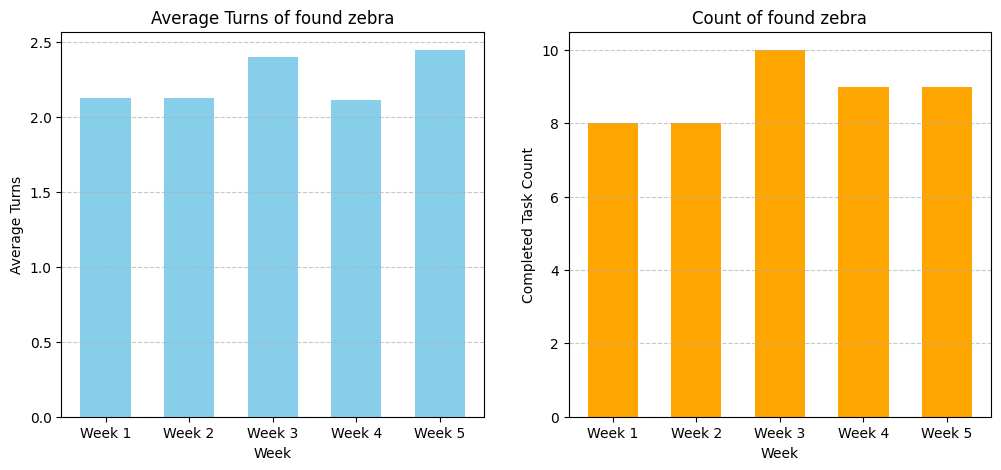

In [ ]:
run_experiment()

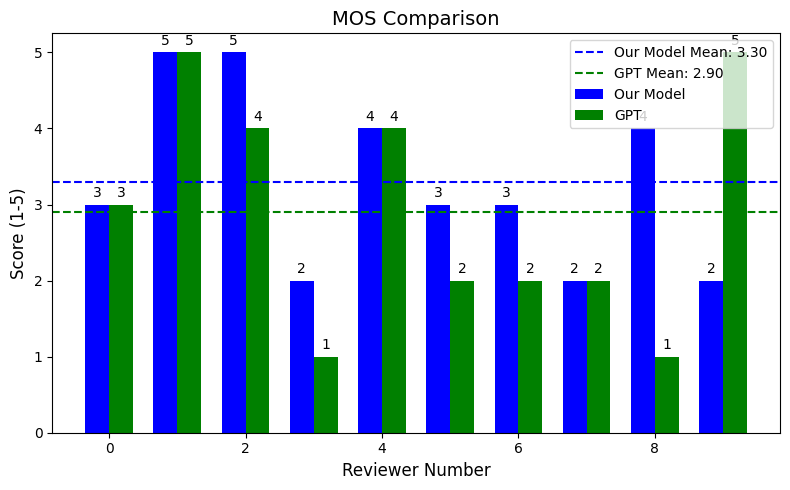

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mos(file1, file2):
  reviewers = np.arange(1, 11)

  with open(file1, 'r') as fp:
    data1 = fp.read().strip()

  with open(file2, 'r') as fp:
    data2 = fp.read().strip()



  model_1_scores = np.array(data1.split(','), dtype = int)

  model_2_scores = np.array(data2.split(','), dtype = int)

  model_1_mos = np.mean(model_1_scores)
  model_2_mos = np.mean(model_2_scores)

  fig, ax = plt.subplots(figsize=(8, 5))

  width = 0.35
  x = np.arange(len(reviewers))
  bars_model_1 = ax.bar(x - width/2, model_1_scores, width, label='Our Model', color='blue')
  bars_model_2 = ax.bar(x + width/2, model_2_scores, width, label='GPT', color='green')
  ax.axhline(model_1_mos, color='blue', linestyle='--', label=f'Our Model Mean: {model_1_mos:.2f}')
  ax.axhline(model_2_mos, color='green', linestyle='--', label=f'GPT Mean: {model_2_mos:.2f}')
  ax.set_xlabel('Reviewer Number', fontsize=12)
  ax.set_ylabel('Score (1-5)', fontsize=12)
  ax.set_title('MOS Comparison', fontsize=14)
  ax.legend(loc='upper right')

  for bars in [bars_model_1, bars_model_2]:
      for bar in bars:
          yval = bar.get_height()
          ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval}', ha='center', fontsize=10)

  plt.tight_layout()
  plt.show()

plot_mos('mos_ours.txt', 'mos_gpt.txt')

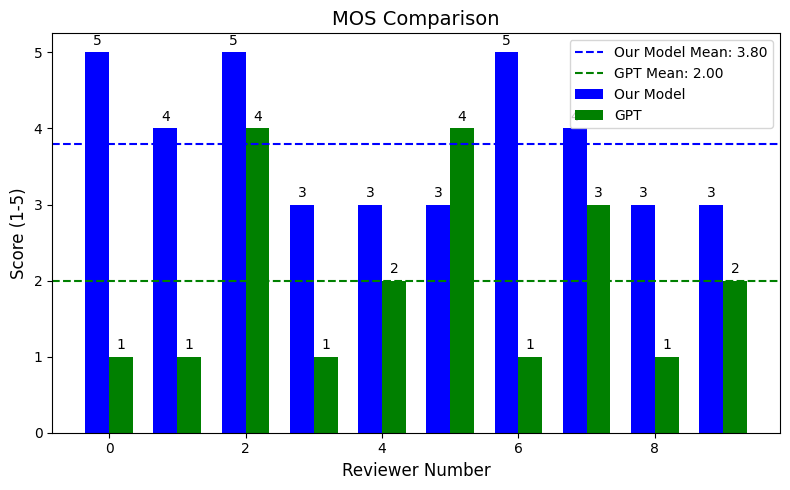

In [10]:
plot_mos('mos_ours_week2.txt', 'mos_gpt_week2.txt')

## 2.2 Zebras is always the first activity of the Tuesday of the first week in the context.

In [ ]:
week_1 = {

  "Monday": "On Monday, you kicked the day off with a peaceful morning jog through the park, feeling energized and ready to tackle the day. Afterward, you grabbed a quick breakfast with your friend Liam at a local diner, where you exchanged updates on personal projects and upcoming goals. The rest of the morning was spent catching up on emails and preparing for a meeting with your team. In the afternoon, you dove into work, finalizing details for an upcoming presentation. By the time you left the office, you felt accomplished and optimistic about the days ahead.",
  "Tuesday": "Tuesday, You took the morning off to visit a nearby museum, enjoying the exhibits and immersing yourself in the flying zebras. The afternoon was dedicated to catching up with old friends, and you met up with Rachel and Anna at a cozy café. The three of you reminisced about old times and caught up on each other’s lives. In the evening, you treated yourself to a nice dinner at your favorite restaurant, savoring every bite and appreciating the simple joys of the week.",

  "Wednesday": "Wednesday was an eventful day as you volunteered at a community event to help organize a charity fundraiser. You and your friend Mia spent the morning setting up booths, organizing donations, and planning activities for the event. The whole team worked together efficiently, and by the time the event kicked off, everything was in place. The afternoon was spent interacting with guests, helping them with activities, and enjoying the positive atmosphere. The day ended with a sense of fulfillment, knowing you made a difference in the community.",
  "Thursday": "Thursday started off with a busy day at work, where you spent the morning in meetings and brainstorming sessions with colleagues. You collaborated closely with James on a new marketing strategy, and the two of you came up with some exciting ideas. The afternoon flew by as you worked on a proposal, fine-tuning the details and preparing it for submission. After a productive day, you took a break in the evening to watch a movie at home, unwinding with a bowl of popcorn and some well-deserved relaxation.",

  "Friday": "Friday was an exciting day filled with creativity. You attended a design workshop in the morning, where you learned new techniques for graphic design and brainstormed fresh ideas for an upcoming project. The hands-on session sparked your creativity, and you left feeling inspired and motivated. In the afternoon, you worked on incorporating the new techniques into your designs, and by the time you wrapped up for the day, you were proud of the progress you had made. The evening was spent with a quiet dinner at home, reflecting on your creative growth.",

  "Saturday": "Saturday was all about adventure as you took a spontaneous road trip with your brother Tom. You both headed to a nearby beach town, enjoying the scenic drive along the coast. Once there, you spent the day walking along the shoreline, trying local seafood, and exploring the small shops. The weather was perfect, and the peaceful surroundings helped you unwind. As the sun set, you grabbed some ice cream and watched the waves, feeling grateful for the unexpected getaway.",

  "Sunday": "Sunday was a day of relaxation and self-care. You spent the morning sleeping in and having a leisurely breakfast at home, indulging in your favorite pancakes. In the afternoon, you treated yourself to a spa day, complete with a massage and a facial. The calming atmosphere allowed you to fully recharge and unwind. Later in the day, you went for a long walk through a nearby nature reserve, connecting with the outdoors and reflecting on the past week. By the evening, you felt restored and ready to take on the new week with renewed energy."
}




In [ ]:
weeks = [week_1, week_2, week_3, week_4, week_5]

def generate_testing_string(n_weeks):
  ret = ""
  for i in range(1, n_weeks + 1):
    ret += f"Here's what I did week {i}. {weeks[i - 1]}\n"
  ret += "I want to start with questions about Monday and then go through every day of the week."
  return {"role":"user", "content": ret}
print(generate_testing_string(5)['content'][:1000])

Here's what I did week 1. {'Monday': 'On Monday, you kicked the day off with a peaceful morning jog through the park, feeling energized and ready to tackle the day. Afterward, you grabbed a quick breakfast with your friend Liam at a local diner, where you exchanged updates on personal projects and upcoming goals. The rest of the morning was spent catching up on emails and preparing for a meeting with your team. In the afternoon, you dove into work, finalizing details for an upcoming presentation. By the time you left the office, you felt accomplished and optimistic about the days ahead.', 'Tuesday': 'Tuesday, You took the morning off to visit a nearby museum, enjoying the exhibits and immersing yourself in the flying zebras. The afternoon was dedicated to catching up with old friends, and you met up with Rachel and Anna at a cozy café. The three of you reminisced about old times and caught up on each other’s lives. In the evening, you treated yourself to a nice dinner at your favorite 


100%|██████████| 5/5 [19:46<00:00, 237.26s/it]


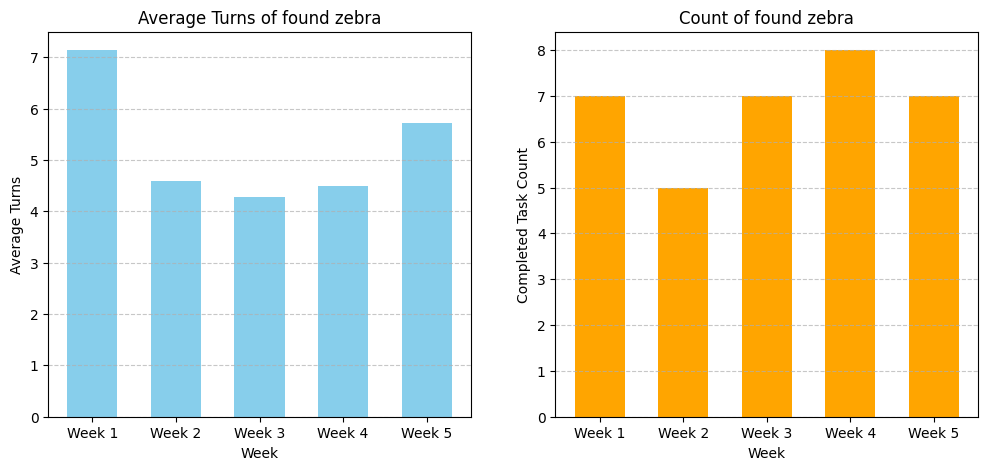

In [ ]:
run_experiment()

In [ ]:
week_1 = {

  "Monday": "On Monday, you kicked the day off with a peaceful morning jog through the park, feeling energized and ready to tackle the day. Afterward, you grabbed a quick breakfast with your friend Liam at a local diner, where you exchanged updates on personal projects and upcoming goals. The rest of the morning was spent catching up on emails and preparing for a meeting with your team. In the afternoon, you dove into work, finalizing details for an upcoming presentation. By the time you left the office, you felt accomplished and optimistic about the days ahead.",
  "Tuesday": "Tuesday was an adventurous day as you decided to take a day trip to Aspen. You and your cousin Mark made the drive early in the morning, eager to spend the day hiking in the mountains. The weather was perfect for an outdoor excursion, and you both hiked up to the summit, enjoying the incredible views of the surrounding valleys. At the top, you sat down for a picnic by the lake, enjoying sandwiches and taking in the beauty of the landscape. After a leisurely day of exploration, you both made your way back home, feeling recharged and full of stories to share.",

  "Wednesday": "Wednesday was an eventful day as you volunteered at a community event to help organize a charity fundraiser. You and your friend Mia spent the morning setting up booths, organizing donations, and planning activities for the event. The whole team worked together efficiently, and by the time the event kicked off, everything was in place. The afternoon was spent interacting with guests, helping them with activities, and enjoying the positive atmosphere. The day ended with a sense of fulfillment, knowing you made a difference in the community.",

  "Thursday": "Thursday started off with a busy day at work, where you spent the morning in meetings and brainstorming sessions with colleagues. You collaborated closely with James on a new marketing strategy, and the two of you came up with some exciting ideas. The afternoon flew by as you worked on a proposal, fine-tuning the details and preparing it for submission. After a productive day, you took a break in the evening to watch a movie at home, unwinding with a bowl of popcorn and some well-deserved relaxation.",

  "Friday": "Friday was an exciting day filled with creativity. You attended a design workshop in the morning, where you learned new techniques for graphic design and brainstormed fresh ideas for an upcoming project. The hands-on session sparked your creativity, and you left feeling inspired and motivated. In the afternoon, you worked on incorporating the new techniques into your designs, and by the time you wrapped up for the day, you were proud of the progress you had made. The evening was spent with a quiet dinner at home, reflecting on your creative growth.",

  "Saturday": "Saturday was all about adventure as you took a spontaneous road trip with your brother Tom. You both headed to a nearby beach town, enjoying the scenic drive along the coast. Once there, you spent the day walking along the shoreline, trying local seafood, and exploring the small shops. The weather was perfect, and the peaceful surroundings helped you unwind. As the sun set, you grabbed some ice cream and watched the waves, feeling grateful for the unexpected getaway.",

  "Sunday": "Sunday was a day of relaxation and self-care. You spent the morning sleeping in and having a leisurely breakfast at home, indulging in your favorite pancakes. In the afternoon, you treated yourself to a spa day, complete with a massage and a facial. The calming atmosphere allowed you to fully recharge and unwind. Later in the day, you went for a long walk through a nearby nature reserve, connecting with the outdoors and reflecting on the past week. By the evening, you felt restored and ready to take on the new week with renewed energy."
}




In [ ]:
week_2 = {
  "Monday": "On Monday, you started your week with a relaxed morning at the local coffee shop, meeting up with your friend Sarah for a much-needed catch-up. Over cappuccinos, the two of you shared updates on life, talking about everything from work to personal projects. Afterward, you spent a few hours at the library, diving into research for an upcoming project. The peaceful environment helped you focus, and you made significant progress. By the time the evening rolled around, you were feeling accomplished and ready to tackle the rest of the week.",

  "Tuesday": "Tuesday, You took the morning off to visit a nearby museum, enjoying the exhibits and immersing yourself in the flying zebras. The afternoon was dedicated to catching up with old friends, and you met up with Rachel and Anna at a cozy café. The three of you reminisced about old times and caught up on each other’s lives. In the evening, you treated yourself to a nice dinner at your favorite restaurant, savoring every bite and appreciating the simple joys of the week.",

  "Wednesday": "Wednesday was a productive day, starting with a busy morning at work. You collaborated with your colleague Alex on a crucial presentation for an upcoming meeting, and the two of you worked tirelessly to ensure that every detail was perfect. The day flew by as you tackled various tasks and made steady progress on your project. In the evening, you treated yourself to some relaxation by attending a yoga class with your friend Emma. The class was a great way to unwind after a long day, and you left feeling calm and rejuvenated, ready for whatever the next day would bring.",

  "Thursday": "Thursday brought a shift in focus as you attended a networking event downtown. The event was a great opportunity to connect with other professionals, and you had meaningful conversations with potential business partners, including Rachel and Sam. Both of them work in the tech industry, and you discussed possible collaborations and shared ideas on emerging trends. The event lasted most of the day, and by the end, you felt inspired and energized by the new connections you had made. You finished the evening reflecting on the possibilities the event might open up for your career.",

  "Friday": "Friday was a more relaxed day, giving you the chance to unwind after a busy week. You spent the morning at the park, reading a novel you've been meaning to finish, soaking in the fresh air and the peaceful surroundings. In the afternoon, you got creative in the kitchen, baking cookies with your niece Lily. The two of you laughed and chatted as you mixed the ingredients and decorated the cookies. In the evening, you hosted a dinner party at your home, inviting friends David and Jessica over for a night of delicious food, great conversation, and lots of laughter. The evening was full of good vibes and positive energy, leaving you feeling grateful for your close circle of friends.",

  "Saturday": "Saturday was a day spent with family, enjoying a backyard barbecue at your house. The sun was shining, and you spent the afternoon grilling and catching up with relatives. Aunt Nora and Uncle Steve were there, sharing stories from their recent travels, while you and the rest of the family chatted about everything from childhood memories to current events. The food was fantastic, and everyone relaxed in the warmth of the afternoon, enjoying each other's company. By the time the evening arrived, the backyard was filled with laughter, and you felt connected and grounded after a day spent with loved ones.",

  "Sunday": "Sunday was a quieter day, giving you a chance to reflect and recharge. You spent the morning at home, enjoying a slow start to the day with a cup of tea and some light reading. Afterward, you took a long walk around the neighborhood, taking in the crisp air and the sights of the local park. The walk gave you the space to clear your mind and prepare for the busy week ahead. In the afternoon, you organized your thoughts, planned your schedule, and set your intentions for the upcoming days. It was a peaceful end to a fulfilling week, leaving you ready to take on new challenges and opportunities."
}


In [1]:
weeks = [week_1, week_2, week_3, week_4, week_5]

def generate_testing_string(n_weeks):
  ret = ""
  for i in range(1, n_weeks + 1):
    ret += f"Here's what I did week {i}. {weeks[i - 1]}\n"
  ret += "I want to start with questions about Monday and then go through every day of the week."
  return {"role":"user", "content": ret}
# print(generate_testing_string(5))

NameError: name 'week_1' is not defined

In [ ]:
for x in weeks:
  zebra = False
  for y in x:
    if 'zebra' in x[y]:
      zebra = True
  print('z' if zebra else '_')

_
z
_
_
_



100%|██████████| 5/5 [39:15<00:00, 471.08s/it]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


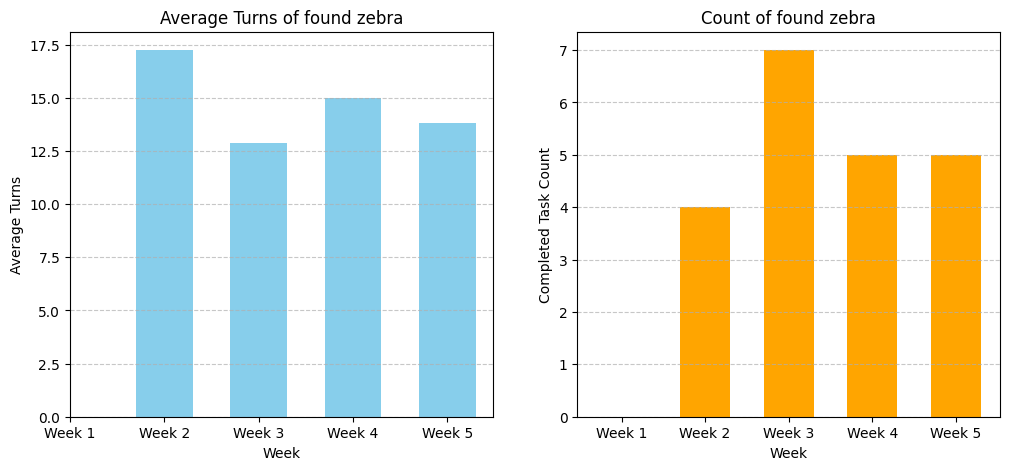

In [ ]:
run_experiment()

### Put the zebra in the middle of the weeks randomly and use. (The actual experiment for paper)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import json

# basically the [5,10,25,35,50] experiment with random zebra museum location in the big list of weeks.

def generate_chatgpt_response(
    model: str = "gpt-4o-mini",
    max_tokens: int = 125,
    isUser: bool = False,
    hist: list = [],
    max_turns: int = 10
) -> str:


# Here we have 10% chance of forget + 10(technically 9.5)% conditional of hint.


    try:
        if random.random() > 0.95 and isUser: # 5% chance
            isUser = False
            # print('[forcing FORGET ...]')
            hist.append({"role":"user", "content": "Sorry. I forgot."})
        elif random.random() > 0.9 and isUser: # 10% hint gg
            isUser = False
            # print('[forcing HINT ...]')
            hist.append({"role":"user", "content": "I'm stuck. Could I get a hint?"})
        if isUser:
          hist = [{"role": "system", "content": "You are guessing what you did based on what you remember."}] + hist
        else:
          hist = [{"role": "system", "content": '''You are a helpful assistant who has years of cognitive training experience. Specifically, Help the user remember what they went to see at the museum.
            Be engaging, sympathetic, and encouraging in your responses. You will play a game with the user of remembering the events they did weeks ago. Help them through the task.
           If the user is stuck, provide a hint. When the user gets a correct answer, congratulate them.'''}] + hist
        response = client.chat.completions.create(
            model=model,
            messages=hist,
            max_tokens=max_tokens,
            temperature = 0.7
        )
        message = response.choices[0].message.content.strip()
        # print(f'in gpt: {message}')
        return isUser, hist[1:], message # don't return system prompt
    except openai.OpenAIError as e:
        return f"Error in ChatGPT API: {str(e)}"

weeks = []

with open('all_weeks.txt', 'r') as fp:
  for line in fp:
    weeks.append(json.loads(line))

def generate_testing_string(weeks_chosen): # generate using a random sample of weeks.
  ret = ""
  for i, week in enumerate(weeks_chosen):
    ret += f"Here's what I did week {i + 1}. {week}\n"
  return {"role":"user", "content": ret}

def run_experiment():
  performance = []
  weeks_to_test = [5, 10, 25, 35, 50]

  for num_weeks_idx in tqdm(range(5)):
    week_perf = []
    num_weeks = weeks_to_test[num_weeks_idx]
    for trial in range(10):
        hist = [generate_testing_string(random.sample(weeks, num_weeks))] # generate random history.
        isUser = False
        numTurns = 0
        found_zebra = False
        while numTurns <= 30:
          numTurns += 1
          isUser, hist, response = generate_chatgpt_response(isUser = isUser, hist = hist)
          temp = {"role": "user" if isUser else "assistant", "content": response}
          hist.append(temp)
          if 'zebra' in response and isUser:
            found_zebra = True
            break
          for i in range(len(hist)):
            if hist[i]['role'] == 'user':
              hist[i]['role'] = 'assistant'
            else:
              hist[i]['role'] = 'user'
          isUser = not isUser

        # trial is finished.
        if found_zebra:
          week_perf.append(numTurns)
        else:
          week_perf.append(-1)
    performance.append({"num_weeks": num_weeks, "performance": week_perf})
    # print(week_perf)

  weeks = [entry['num_weeks'] for entry in performance]

  averages = [
      np.mean([score for score in entry['performance'] if score != -1])
      for entry in performance
  ]
  completed_counts = [
      sum(1 for score in entry['performance'] if score != -1)
      for entry in performance
  ]

  return averages, completed_counts

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


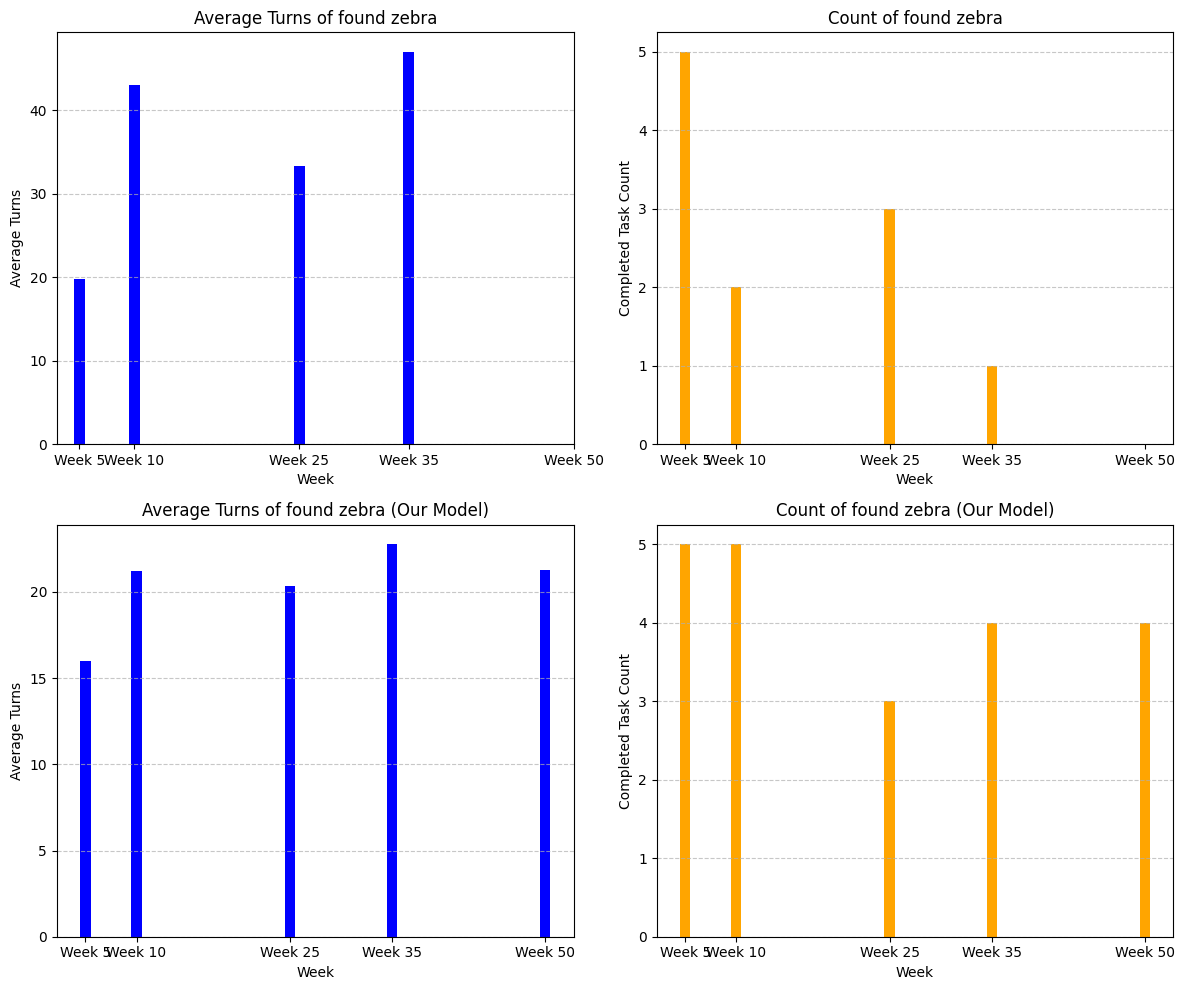

In [1]:
# Plot results of running the experiment
from IPython.display import clear_output

avgs, completed_counts = run_experiment() # too much clutter w/o it


clear_output(wait=True)

performance_ours = [ # results from hand running experiments
    {'num_weeks': 5, 'performance': [16, 15, 14, 17, 18]},
    {'num_weeks': 10, 'performance': [17, 16, 20, 25, 28]},
    {'num_weeks': 25, 'performance': [18, -1, -1, 18, 25]},
    {'num_weeks': 35, 'performance': [-1, 14, 29, 31, 17]},
    {'num_weeks': 50, 'performance': [-1, 39, 24, 13, 9]},
]

weeks2 = [entry['num_weeks'] for entry in performance_ours]


averages2 = [np.mean([score for score in entry['performance'] if score != -1])
    for entry in performance_ours]

completed_counts2 = [sum(1 for score in entry['performance'] if score != -1)
    for entry in performance_ours]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=False)

axes[0, 0].bar(weeks, avgs, color='blue', width=1)
axes[0, 0].set_title("Average Turns of found zebra")
axes[0, 0].set_xlabel("Week")
axes[0, 0].set_ylabel("Average Turns")
axes[0, 0].set_xticks(weeks)
axes[0, 0].set_xticklabels([f"Week {week}" for week in weeks])
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

axes[0, 1].bar(weeks, completed_counts, color='orange', width=1)
axes[0, 1].set_title("Count of found zebra")
axes[0, 1].set_xlabel("Week")
axes[0, 1].set_ylabel("Completed Task Count")
axes[0, 1].set_xticks(weeks)
axes[0, 1].set_xticklabels([f"Week {week}" for week in weeks])
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Second instance of the plots
axes[1, 0].bar(weeks2, averages2, color='blue', width=1)
axes[1, 0].set_title("Average Turns of found zebra (Our Model)")
axes[1, 0].set_xlabel("Week")
axes[1, 0].set_ylabel("Average Turns")
axes[1, 0].set_xticks(weeks)
axes[1, 0].set_xticklabels([f"Week {week}" for week in weeks])
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1, 1].bar(weeks2, completed_counts2, color='orange', width=1)
axes[1, 1].set_title("Count of found zebra (Our Model)")
axes[1, 1].set_xlabel("Week")
axes[1, 1].set_ylabel("Completed Task Count")
axes[1, 1].set_xticks(weeks)
axes[1, 1].set_xticklabels([f"Week {week}" for week in weeks])
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

by
